# Ocotillo Valley

In [280]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf

## Pre-process GIS files to convert them into MODFLOW-friendly csv files ##

In [281]:
run = False    #to run this section, set to True
if run:         #if run is True, run the section
    files = ['dem','valley','recharge','ag','riparian','stream','stage','wells']
    fig,ax = plt.subplots(1,len(files), figsize=(30,10))
    for i,f in enumerate(files):
        a = np.asarray(pd.read_csv(f+'1000.txt', header=None, skiprows=6, delimiter=' ', na_values=-9999))
        #print(np.shape(a))
        a = a[65:315,110:255]
        #print(np.shape(a))
        if f == 'recharge':
            a[a>0] = 1
        ax[i].imshow(a)
        np.savetxt(f+'.csv', a, delimiter=',')

## Model set up ##

In [282]:
##Name:
modelname = "ocotillo"

##Grid:
topo = np.genfromtxt('dem.csv', delimiter=',')   #load the model topography from a csv file. It will then be used to define the model grid.
nrow = np.shape(topo)[0]          #number of rows
ncol = np.shape(topo)[1]          #number of columns
delr = 1000.                      #width of each cell along rows (so really this is column width along x axis)
delc = 1000.                      #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr                    #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc                    #width of domain in y (across rows) = number of rows x cell height

##Layers:
nlay = 4                                                #number of layers
layers = np.arange(nlay)                                #make array of layers
ztop = topo.copy()                                      #make a copy of the topo array to use for MODFLOW
ztop[np.isnan(ztop)] = np.nanmean(topo)                     #replace nan values with max elevation (mostly for plotting)
zbot = -500.                                               #bottom elevation of model (datum)
botm = np.full((nlay,nrow,ncol),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm[0,:,:] = zbot+450                                   #for the top layer, set the bottom elevation of that layer
botm[1,:,:] = zbot+350                                   #for the second layer, set the bottom elevation
botm[2,:,:] = zbot+300                                   #for the third layer, set the bottom elevation to be the model bottom plus some thickness
botm[3,:,:] = zbot                                       #for the bottom layer, set the bottom elevation equal to the model bottom

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
Kx = np.full((nlay,nrow,ncol),100)         #create array of default horizontal hydraulic conductivity (along rows)
Kx[0,40:nrow,60:90] = 145                      #set Kx in layer 0, along a north-south strip, to be higher (to represent high-K alluvial sediments)
Kx[2,:,:] = 20                             #set Kx in layer 2 to be lower (to represent a confining unit)
Kx[3,:,:] = 70                             #set Kx in layer 3 to be between layer 0 and layer 2 (to represent older more compacted units)
K_ratio = 1      #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
Kz = np.full((nlay,nrow,ncol),10)         #create array of default vertical hydraulic conductivity (between layers, along z axis)
Kz[0,40:nrow,60:90] = 15                      #set Kz in layer 0, along a north-south strip, to be higher (to represent high-K alluvial sediments)
Kz[2,:,:] = 5                             #set Kz in layer 2 to be lower (to represent a confining unit)
Kz[3,:,:] = 7                             #set Kz in layer 3 to be between layer 0 and layer 2 (to represent older more compacted units)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1              #porosity
Ss = 0.0001           #storage coefficient (how much water from compaction)
Sy = 0.1              #specific yield (how much water from desaturation)
uncnf = [0,0,0,1]     #whether each layer is confined or unconfined. if 0 then confined, if >0 then unconfined

In [288]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((nlay,nrow,ncol),0)                            #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[:,:,:] =  np.genfromtxt('valley.csv', delimiter=',')     #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[ibound!=1] = 0                                           #set all inactive cells equal to zero
ibound[:,nrow-1,:] = -1                                         #replace southernmost row (slice all layers, active rows, last column) with -1 to indicate constant head

#create array of initial head values across the model and at the boundaries
strt = np.full((nlay, nrow, ncol), ztop-10)  #make array of initial head in all cells and set it to 10 m below land surface

In [325]:
## Recharge
rech = np.genfromtxt('recharge.csv', delimiter=',')  #load csv file with recharge zones (1=recharge zone, nan=no recharge)
rech[np.isnan(rech)] = 0                             #set nan values to 0 so MODFLOW doesn't panic
rech[rech==1] = 1e-5                                #set values in recharge zone equal to recharge rate

In [326]:
##Sections that rarely change:

##Outputs: we are telling the model which outputs to print
oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=Kx, hani=K_ratio, vka=Kz, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                       #RCH (Recharge)
#strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, ntrib=0, ndiv=0,icalc=icalc, const=const, ipakcb=ipakcb,  istcb2=istcb2, dtype=None,
#        stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)
#evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)  #EVT (Evapotranspiration) - note: your computer may try to read this as an event log file
#wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=well_spd)     #WEL (Well)  

## Display summary of model inputs ##

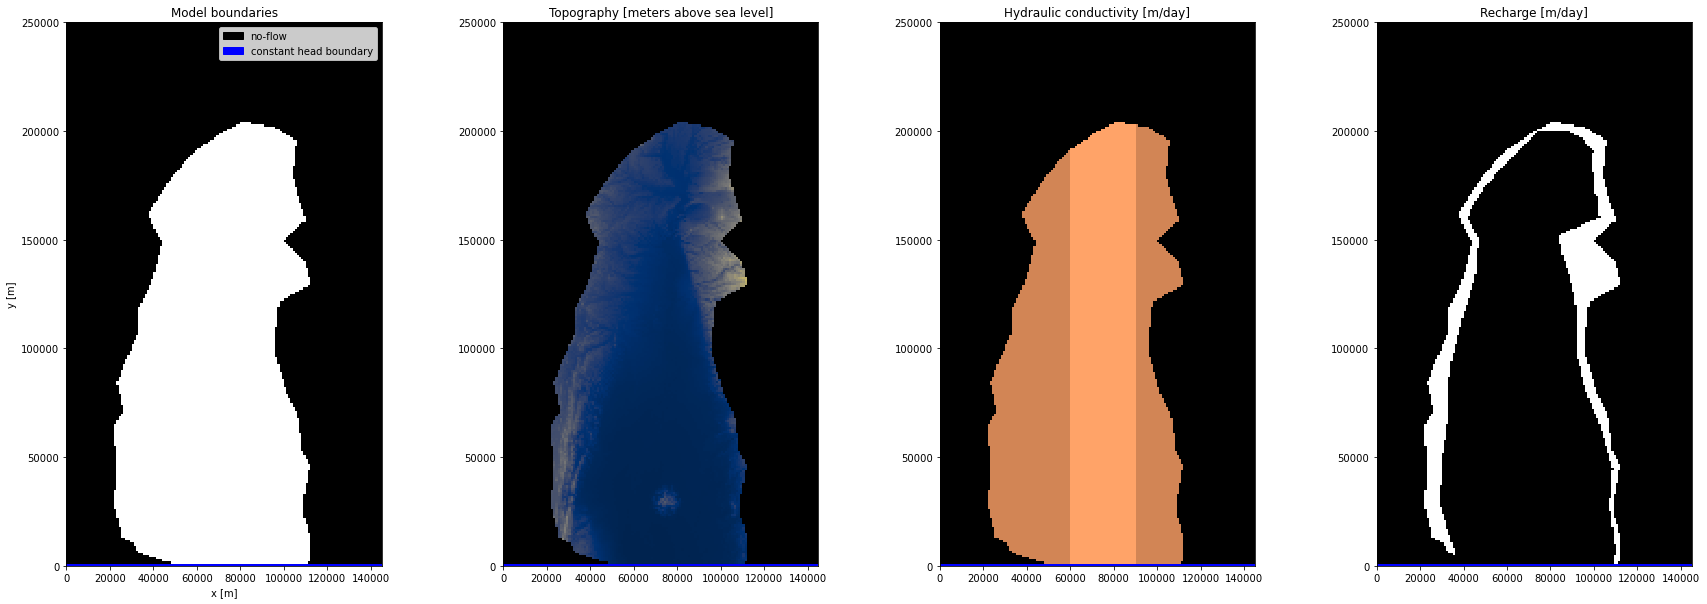

In [327]:
#Plot model boundaries and hydraulic properties:
f,ax = plt.subplots(1,4,figsize=(30,10))                    #create new figure and axes with subplots
ax[0].set_aspect('equal')
ax[0].set_title('Model boundaries')      #set first subplot title
m = flopy.plot.PlotMapView(model=mf, ax=ax[0], layer=0)     #create model map object on first subplot axes
#grid = m.plot_grid(colors='gray')                           #plot model grid
bc = m.plot_ibound()                                         #plot boundary conditions
#s = m.plot_bc("STR", color='skyblue')                       #plot stream
#w = m.plot_bc("WEL", color='red')                           #plot wells
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
ax[0].legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                   matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                   # matplotlib.patches.Patch(color='skyblue', label='stream'),
                   # matplotlib.patches.Patch(color='red', label='well')
                    ])

ax[1].set_title('Topography [meters above sea level]')      #set first subplot title
ax[1].set_aspect('equal')
m = flopy.plot.PlotMapView(model=mf, ax=ax[1], layer=0)     #create model map object on first subplot axes
t = m.plot_array(topo, cmap='cividis', vmin=0, vmax=1500)   #plot topography array
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[2], layer=0)     #create model map object on second subplot axes
ax[2].set_aspect('equal')
ax[2].set_title('Hydraulic conductivity [m/day]')           #set first subplot title
k = m.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)    #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[3], layer=0)     #create model map object on second subplot axes
ax[3].set_aspect('equal')
ax[3].set_title('Recharge [m/day]')                         #set first subplot title
k = m.plot_array(rech, cmap='bone')                         #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

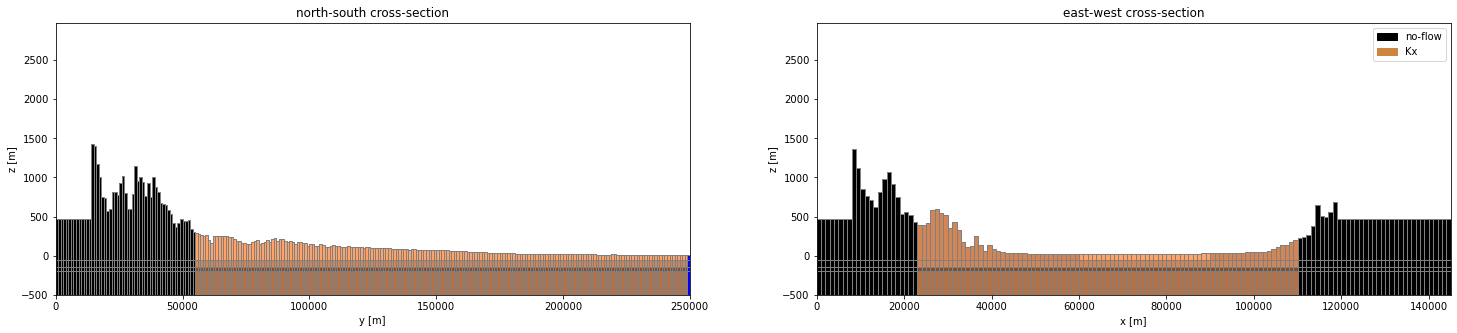

In [328]:
#Plot cross-section view of model:
row = 200
col = 65

#South-North:
f,ax = plt.subplots(1,2, figsize=(25,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})   #plot cross-section along given column (change column # to see different locations)
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                #plot horizontal K as an array, with color range set manually to be consistent with other plots
#h  = xsec.plot_array(strt, head=strt)                                                   #plot starting heads as an array, with color range set manually to be consistent with other plots
bc = xsec.plot_ibound()                                                      #plot boundary conditions
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})    #plot cross-ection along stream row
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                #plot heads as an array, with color range set manually to be consistent with other plots
#h  = xsec.plot_array(strt, head=strt)                                       #plot starting heads as an array, with color range set manually to be consistent with other plots
bc = xsec.plot_ibound()                                                     #plot boundary conditions
g  = xsec.plot_grid()                                                       #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

plt.legend(handles=[matplotlib.patches.Patch(color='k',label='no-flow'),
                    matplotlib.patches.Patch(color='peru',label='Kx')]) #add legend manually

## Run model ##
The code in this section will change very little

In [329]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ocotillo.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/02/24 17:12:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/02/24 17:12:55
 Elapsed run time:  3.543 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
